<a href="https://colab.research.google.com/github/brandontan99/Self_Love_App/blob/master/Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [1]:
%cd /content
!git clone https://github.com/brandontan99/Self_Love_App.git
%cd /content/Self_Love_App
!pip install scikit-multilearn

import sys 
sys.path.append("./preprocessing")
sys.path.append("./utils")
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import RidgeClassifierCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from skmultilearn.adapt import *
from skmultilearn.problem_transform import *
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
import pandas as pd
from scipy import sparse
import numpy as np
import matplotlib.pyplot as plt
import time
import pickle

from data_cleaning import data_cleaning
from Data_Normalization import data_encoding, data_normalization
from feature_selection import *

# random seed to ensure reproducibility
seed = 1

/content
Cloning into 'Self_Love_App'...
remote: Enumerating objects: 246, done.
remote: Counting objects: 100% (246/246), done.
remote: Compressing objects: 100% (214/214), done.
remote: Total 246 (delta 138), reused 67 (delta 27), pack-reused 0
Receiving objects: 100% (246/246), 2.91 MiB | 9.06 MiB/s, done.
Resolving deltas: 100% (138/138), done.
/content/Self_Love_App
     |████████████████████████████████| 92kB 4.9MB/s 


# Data Preparation

In [ ]:
# read and preprocess the csv file generated from google form 
df = pd.read_csv("WID3006 ML Questionnaire.csv")
df_cleaned = data_cleaning(df) # clean and group the hobbies 
df_encoded = data_encoding(df_cleaned) # one-hot encoding 
df_norm = data_normalization(df_encoded) # normalise the data value to a range from 0 to 1
df_norm

,Gender: _Male,What is your current occupation?_Retired,What is your current occupation?_Unemployed,What is your current occupation?_University student,What boosts your confidence ? _By leading others to success,What boosts your confidence ? _Get the most/ special attention among the members,What boosts your confidence ? _When someone acknowledges you,What boosts your confidence ? _When you accomplish a project,I prefer to spend my money on...._Food,I prefer to spend my money on...._Home Improvements,I prefer to spend my money on...._The latest fashion,I prefer to spend my money on...._The latest technology,How do you organize your thoughts? Please pick whichever is closest._I make a chart or graph,How do you organize your thoughts? Please pick whichever is closest._I talk to myself out loud,How do you organize your thoughts? Please pick whichever is closest._I write it down in my calendar,How do you organize your thoughts? Please pick whichever is closest._Jotting it down on a scrap of paper,Choose a pet which you prefer to keep._Cat,Choose a pet which you prefer to keep._Dog,Choose a pet which you prefer to keep._Fish,Choose a pet which you prefer to keep._Hamster,Choose a pet which you prefer to keep._Horse,Choose a pet which you prefer to keep._I'm not a pet person,Choose a pet which you prefer to keep._Rabbit,Choose a pet which you prefer to keep._Snake,Choose a pet which you prefer to keep._Tortoise,What is your favorite time of the day?_Evening,What is your favorite time of the day?_Morning,What is your favorite time of the day?_Night,Would you rather visit the future or the past?_The future,Would you rather visit the future or the past?_The past,What do you worry more about the most?_Money,What do you worry more about the most?_The state of the world,What do you worry more about the most?_Your family and friends,What do you worry more about the most?_Your future,"When you retire, you'd like to live..._Exactly where I live now","When you retire, you'd like to live..._In a hectic big city","When you retire, you'd like to live..._In a small town","When you retire, you'd like to live..._Overseas","When you retire, you'd like to live..._Traveling the world",What is your favorite color?_Blue,What is your favorite color?_Green,What is your favorite color?_Purple,What is your favorite color?_Red,What is your favorite color?_White,What is your favorite color?_Yellow,What is your learning style? (Pick one that benefit you the most)_By attending online courses,What is your learning style? (Pick one that benefit you the most)_By doing assignments,What is your learning style? (Pick one that benefit you the most)_By doing tutorial/lab questions,What is your learning style? (Pick one that benefit you the most)_By reading a physical book,What is your learning style? (Pick one that benefit you the most)_By reading an e-Book,Do you enjoy socializing with large groups of people?,Do you enjoy challenges?,How creative of a person do you think you are?,How logical of a person do you think you are?,Would you prefer to engage your brain more than your body?,Are you a curious person?,Are you a perfectionist?,Are you a trusting person?,Do you have lot of patience?,Do you organize your schedule well?,Do you like to sit in front of a computer for long hours?,Do you enjoy making others happy?,Can you understand others' perspectives and feelings?,How confident are you in your own abilities?,Sports and Outdoors,Games,Spiritual and Mental,Performing Arts,Arts and Craft,Food and Drinks,Collecting,Rejuvenation
0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0.25,0.50,0.75,0.75,0.75,0.75,0.75,0.75,0.75,0.75,1.00,0.75,0.50,0.50,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
1,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0.75,0.75,0.75,0.75,0.50,1.00,1.00,0.50,0.75,0.75,0.75,1.00,0.75,1.00,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
2,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,

In [ ]:
# check the index and the question columns
for i, name in enumerate(df_norm.columns):
  print(i, name)

0 Gender: _Male
1 What is your current occupation?_Retired
2 What is your current occupation?_Unemployed
3 What is your current occupation?_University student
4 What boosts your confidence ? _By leading others to success
5 What boosts your confidence ? _Get the most/ special attention among the members
6 What boosts your confidence ? _When someone acknowledges you
7 What boosts your confidence ? _When you accomplish a project
8 I prefer to spend my money on...._Food
9 I prefer to spend my money on...._Home Improvements
10 I prefer to spend my money on...._The latest fashion
11 I prefer to spend my money on...._The latest technology
12 How do you organize your thoughts? Please pick whichever is closest._I make a chart or graph
13 How do you organize your thoughts? Please pick whichever is closest._I talk to myself out loud
14 How do you organize your thoughts? Please pick whichever is closest._I write it down in my calendar
15 How do you organize your thoughts? Please pick whichever is 

In [ ]:
# filter the features to be trained on according to the feature importance from rfe or chi2 test
x = filter_features(best_k_features, df_norm)
x

,Gender: _Male,What is your current occupation?_Retired,What is your current occupation?_Unemployed,What is your current occupation?_University student,What boosts your confidence ? _By leading others to success,What boosts your confidence ? _Get the most/ special attention among the members,What boosts your confidence ? _When someone acknowledges you,What boosts your confidence ? _When you accomplish a project,I prefer to spend my money on...._Food,I prefer to spend my money on...._Home Improvements,I prefer to spend my money on...._The latest fashion,I prefer to spend my money on...._The latest technology,How do you organize your thoughts? Please pick whichever is closest._I make a chart or graph,How do you organize your thoughts? Please pick whichever is closest._I talk to myself out loud,How do you organize your thoughts? Please pick whichever is closest._I write it down in my calendar,How do you organize your thoughts? Please pick whichever is closest._Jotting it down on a scrap of paper,Choose a pet which you prefer to keep._Cat,Choose a pet which you prefer to keep._Dog,Choose a pet which you prefer to keep._Fish,Choose a pet which you prefer to keep._Hamster,Choose a pet which you prefer to keep._Horse,Choose a pet which you prefer to keep._I'm not a pet person,Choose a pet which you prefer to keep._Rabbit,Choose a pet which you prefer to keep._Snake,Choose a pet which you prefer to keep._Tortoise,What is your favorite time of the day?_Evening,What is your favorite time of the day?_Morning,What is your favorite time of the day?_Night,What do you worry more about the most?_Money,What do you worry more about the most?_The state of the world,What do you worry more about the most?_Your family and friends,What do you worry more about the most?_Your future,"When you retire, you'd like to live..._Exactly where I live now","When you retire, you'd like to live..._In a hectic big city","When you retire, you'd like to live..._In a small town","When you retire, you'd like to live..._Overseas","When you retire, you'd like to live..._Traveling the world",What is your favorite color?_Blue,What is your favorite color?_Green,What is your favorite color?_Purple,What is your favorite color?_Red,What is your favorite color?_White,What is your favorite color?_Yellow,What is your learning style? (Pick one that benefit you the most)_By attending online courses,What is your learning style? (Pick one that benefit you the most)_By doing assignments,What is your learning style? (Pick one that benefit you the most)_By doing tutorial/lab questions,What is your learning style? (Pick one that benefit you the most)_By reading a physical book,What is your learning style? (Pick one that benefit you the most)_By reading an e-Book,Do you enjoy socializing with large groups of people?,Do you enjoy challenges?,How creative of a person do you think you are?,How logical of a person do you think you are?,Would you prefer to engage your brain more than your body?,Are you a perfectionist?,Are you a trusting person?,Do you have lot of patience?,Do you organize your schedule well?,Do you like to sit in front of a computer for long hours?,Do you enjoy making others happy?,Can you understand others' perspectives and feelings?,How confident are you in your own abilities?
0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0.25,0.50,0.75,0.75,0.75,0.75,0.75,0.75,0.75,1.00,0.75,0.50,0.50
1,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0.75,0.75,0.75,0.75,0.50,1.00,0.50,0.75,0.75,0.75,1.00,0.75,1.00
2,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0.25,0.75,0.75,1.00,1.00,1.00,1.00,0.50,1.00,1.00,1.00,1.00,0.75
3,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0.75,0.75,0.50,0.75,0.50,0.75,0.75,0.75,0.75,0.75,0.75,0.75,0.75
4,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,

In [ ]:
# split the dataset into features(x) and targets(y)
x = df_norm.iloc[:, :64]
y = df_norm.iloc[:, 64:]

In [ ]:
# split the dataset into 75% train and 25% test set (validation set is not needed due to the use of K-fold cross validation)
test_size = 0.25
x_numpy, y_numpy = x.to_numpy(), y.to_numpy()
x_train, x_test, y_train, y_test = train_test_split(x_numpy, y_numpy, test_size=test_size, random_state=seed)
print("Number of train dataset:", len(x_train))
print("Number of test dataset:", len(x_test))

Number of train dataset: 144
Number of test dataset: 48


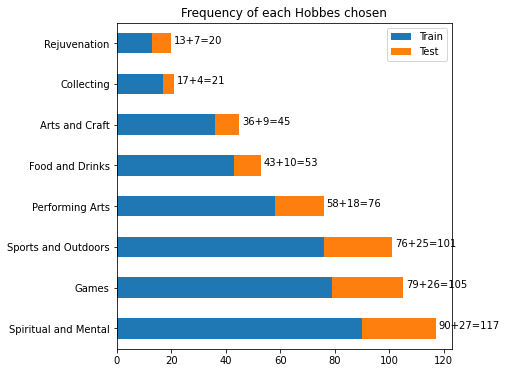

In [ ]:
# draw the distribution of the hobbies with a horizontal bar chart
distribution_of_hobbies = y.sum().sort_values(ascending=False)
distribution_of_hobbies_train_test = pd.DataFrame(np.concatenate([y_train.sum(axis=0)[:,None], y_test.sum(axis=0)[:,None]], axis=1), index=y.columns, columns=["Train","Test"])
distribution_of_hobbies_train_test = distribution_of_hobbies_train_test.reindex(distribution_of_hobbies.index)
distribution_of_hobbies_train_test.plot(kind='barh', figsize=(6, 6), title="Frequency of each Hobbes chosen", stacked=True)

# put the frequency text on the right of the bar chart
for i, (row_index, row) in enumerate(distribution_of_hobbies_train_test.iterrows()):
  train_value = row["Train"]
  test_value = row["Test"]
  sum_value = train_value + test_value
  plt.text(x=sum_value+1 , y =i , s=f"{int(train_value)}+{int(test_value)}={int(sum_value)}" , fontdict=dict(fontsize=10))

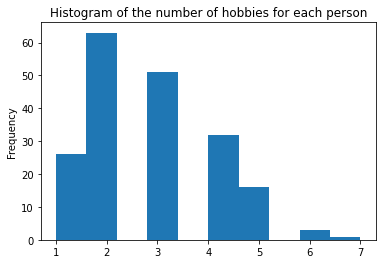

In [ ]:
# draw the histogram of the number of hobbies for each person
y.sum(axis=1).plot.hist(title='Histogram of the number of hobbies for each person')

# Models

### Define the models with a list of hyperparameters of the models

In [ ]:
# Base Classifiers ( dict format --> (name, func) : params )
base_models = {
    ("Decision_Tree", DecisionTreeClassifier) : {'min_samples_split':range(2,5) , 'min_samples_leaf':range(1,4),'min_weight_fraction_leaf':[0.0,0.5],'random_state':[seed]},
    ("Extra_Trees", ExtraTreesClassifier) : {'n_estimators':range(90,120,10),'min_samples_split':range(2,5) , 'min_samples_leaf':range(1,4),'n_jobs':[-1],'random_state':[seed]},
    ("Random_Forest", RandomForestClassifier) :{'n_estimators':range(90,120,10),'min_samples_split':range(2,5),'min_samples_leaf':range(1,4),'n_jobs':[-1],'random_state':[seed]},
    ("MLP", MLPClassifier) : {'hidden_layer_sizes': [(128,64,32),(64,32),(64)],'alpha':[1e-3, 1e-2, 1e-1], 'max_iter': [2000],'random_state':[seed]},
    ("Ridge", RidgeClassifierCV) : {'fit_intercept':[True]}
}

# Adaptation approaches
adapt_models = {
    ("Binary_Relevance_kNN_A", BRkNNaClassifier) : {'k': range(1,3)},
    ("Binary_Relevance_kNN_B", BRkNNbClassifier) : {'k': range(1,3)},
    ("Multi-Label_KNN", MLkNN) : {'k': range(1,3), 's': [0.5, 0.7, 1.0]},
    ("ARAM_Neural_Network", MLARAM) : {'threshold':[0.05], 'vigilance':[0.95]},
    ("Twin_SVM", MLTSVM) : {'c_k': [2**i for i in range(-5, 5, 2)]} # need sparse input
}

# Problem Transformation
problem_transform = {
    "Binary_Relevance" : BinaryRelevance,
    "Classifier_Chain" : ClassifierChain
}

# Hyperparameters

In [ ]:
# Hyperparameters Tuning
num_of_kfold_splits = 5

# Training

### Adaptation approaches

In [ ]:
results = {}
scoring = 'f1_micro' # to evaluate on imbalanced dataset
y_sparse = sparse.csr_matrix(y_train)
x_sparse = sparse.csr_matrix(x_train)
for (model_name, model), params in adapt_models.items():
  kfold = KFold(n_splits=num_of_kfold_splits, random_state=None)
  # use GridSearchCV to find the best hyperparameters and use cross validation to train on train and validation set eventually
  clf = GridSearchCV(model(), params, cv=kfold, n_jobs=-1, scoring=scoring) 
  if model_name == "Twin_SVM": # this model need sparse input
    clf.fit(x_sparse, y_sparse)
  else:
    clf.fit(x_train, y_train)
  results[model_name] = clf
  print(model_name,clf.best_score_)

Binary_Relevance_kNN_A 0.4823135496896695
Binary_Relevance_kNN_B 0.22701983420659094
Multi-Label_KNN 0.4823135496896695
ARAM_Neural_Network 0.48741973938422334
Twin_SVM 0.5322630549362678


### Problem Transformation

In [ ]:
scoring = 'f1_micro' # to evaluate on imbalanced dataset
x_train, x_test, y_train, y_test = train_test_split(x_numpy, y_numpy, test_size=test_size, random_state=seed)
for strategy_name, strategy in problem_transform.items():
  for (model_name, model), params in base_models.items():
    parameters = {}
    for param_name, param_value in params.items():
      parameters["classifier__"+param_name] = param_value
    kfold = KFold(n_splits=num_of_kfold_splits, random_state=None) 
    # use GridSearchCV to find the best hyperparameters and use cross validation to train on train and validation set eventually
    clf = GridSearchCV(strategy(classifier=model()), parameters, cv=kfold, n_jobs=-1, scoring=scoring) 
    clf.fit(x_train, y_train)
    results[f"{strategy_name}_{model_name}"] = clf
    print(f"{strategy_name}_{model_name}",clf.best_score_)

Binary_Relevance_Extra_Trees 0.554058698870729


# Evaluation 

In [ ]:
def display_evaluation_result(results, y, x_test, y_test, distribution_of_hobbies_train_test, f1_average = "micro"):
  result_table = []
  for model_name, model in results.items():
    y_pred = model.predict(x_test)
    score = f1_score(y_test, y_pred, average=f1_average)
    score_by_class = f1_score(y_test, y_pred, average=None, zero_division=0)
    result_table.append([score]+score_by_class.tolist())

  # f1 score evaluation result overall and by class in percentage 
  # 0 means no True Positive at all or there is no example of that class in the y_text at all
  result_table_df = pd.DataFrame(result_table, columns=["Overall"]+y.columns.tolist(), index=results.keys()) * 100
  result_table_df.sort_values(by='Overall', inplace=True, ascending=False)

  # arrange the columns according to the frequency of each hobbies in the test set
  sorted_columns = distribution_of_hobbies_train_test["Test"].sort_values(ascending=False).index.tolist()
  modified_column_names = [column + "(" + str(int(distribution_of_hobbies_train_test.loc[column,"Test"]))+")" for column in sorted_columns]
  result_table_df = result_table_df[["Overall"] + sorted_columns] # sort the columns by the frequency of each hobbies in the test set 
  result_table_df.columns = [["Overall"] + modified_column_names] # add the frequency of each hobbies in the test set beside the column name
  return result_table_df

display_evaluation_result(results, y, x_test, y_test, distribution_of_hobbies_train_test, f1_average = "micro")

,Overall,Spiritual and Mental(27),Games(26),Sports and Outdoors(25),Performing Arts(18),Food and Drinks(10),Arts and Craft(9),Rejuvenation(7),Collecting(4)
Binary_Relevance_Random_Forest,61.847390,78.787879,67.741935,70.370370,42.857143,42.857143,28.571429,0.000000,0.000000
Binary_Relevance_MLP,61.596958,78.688525,77.192982,70.588235,36.363636,36.363636,50.000000,36.363636,0.000000
Classifier_Chain_Ridge,60.728745,81.250000,67.857143,67.924528,42.424242,26.666667,40.000000,0.000000,0.000000
Classifier_Chain_Extra_Trees,60.483871,81.250000,73.684211,61.538462,42.424242,40.000000,13.333333,25.000000,0.000000
Binary_Relevance_Ridge,60.240964,78.787879,67.857143,67.924528,42.424242,26.666667,40.000000,0.000000,0.000000
Binary_Relevance_Extra_Trees,59.751037,78.125000,70.175439,62.745098,41.176471,30.769231,20.000000,25.000000,0.000000
Classifier_Chain_Random_Forest,58.333333,76.056338,70.175439,64.150943,42.857143,0.000000,0.000000,0.000000,0.000000
Binary_Relevance_Decision_Tree,57.777778,72.000000,70.270270,68.493151,0.000000,0.000000,0.000000,0.000000,0.000000
Classifier_Chain_Decision_Tree,57.777778,72.000000,70.270270,68.493151,0.000000,0.000000,0.000000,0.000000,0.000000
Classifier_Chain_MLP,57.480315,74.576271,75.471698,64.000000,41.176471,28.571429,42.105263,20.000000,0.000000


# Feature Selection

### Chi Square Analysis
https://machinelearningmastery.com/feature-selection-with-real-and-categorical-data/

In [ ]:
# label encoding is used instead of one-hot encoding because one-hot encoding will create many features for one question
# but label encoding is able to perform chi-square test between a single question as a whole and the hobby  
x_df, y_df = label_encoding(df_cleaned)
# only evaluate on train data to prevent data leakage
x_train_label_encoded, _, y_train, _ = train_test_split(x_df.to_numpy(), y_df.to_numpy(), test_size=test_size, random_state=seed)
chi2_result = chi2_analysis(x_train_label_encoded, x_df, y_train)
chi2_result 

,0
Gender:,3.764270
What is your favorite color?,2.842968
Choose a pet which you prefer to keep.,1.751194
How do you organize your thoughts? Please pick whichever is closest.,1.496273
"When you retire, you'd like to live...",1.012028
How confident are you in your own abilities?,0.912921
What is your learning style? (Pick one that benefit you the most),0.878989
What boosts your confidence ?,0.863392
Do you like to sit in front of a computer for long hours?,0.848999
Do you organize your schedule well?,0.847976


The table above shows the score for each questions with respect to the hobbies.

##### Evaluation

In [ ]:
# train and evaluate the model with top k best features to determine the best number of features
# Binary Relevance of ExtraTreesClassifier is used in this case
params = base_models[("Extra_Trees", ExtraTreesClassifier)]
params = {"classifier__"+param_name:param for param_name, param in params.items()}
params["classifier"] = [ExtraTreesClassifier()]
scoring = 'f1_micro'

results = {}
for i in range(len(chi2_result.index)):
  best_k_features = select_best_k_features(chi2_result, k=i+1)
  x = filter_features(best_k_features, df_norm)
  x_numpy, y_numpy = x.to_numpy(), y.to_numpy()
  x_train, x_test, y_train, y_test = train_test_split(x_numpy, y_numpy, test_size=test_size, random_state=seed)
  clf = GridSearchCV(BinaryRelevance(), params, cv=5, n_jobs=-1, scoring=scoring)
  clf.fit(x_train, y_train)
  y_pred = clf.predict(x_test)
  score = f1_score(y_test, y_pred, average="micro")
  print("Number of best k features:", len(best_k_features), "score:",score)

Number of best k features: 1 score: 0.5045871559633027
Number of best k features: 2 score: 0.547008547008547
Number of best k features: 3 score: 0.5477178423236514
Number of best k features: 4 score: 0.5414847161572052
Number of best k features: 5 score: 0.5316455696202531
Number of best k features: 6 score: 0.5583333333333333
Number of best k features: 7 score: 0.5819672131147541
Number of best k features: 8 score: 0.6260162601626018
Number of best k features: 9 score: 0.6008230452674898
Number of best k features: 10 score: 0.5991902834008097
Number of best k features: 11 score: 0.5867768595041322
Number of best k features: 12 score: 0.5941422594142258
Number of best k features: 13 score: 0.6040816326530611
Number of best k features: 14 score: 0.5748987854251012
Number of best k features: 15 score: 0.5843621399176955
Number of best k features: 16 score: 0.6122448979591836
Number of best k features: 17 score: 0.5943775100401607
Number of best k features: 18 score: 0.592
Number of best 

Based on the scores above, the best number of features is 8 with 62.6% f1_micro score followed by 23 with 62.04% f1_micro score. 

In [ ]:
# 8 questions as the features has the best result
best_k_features = select_best_k_features(chi2_result, k=8)
best_k_features # below is the list of top 8 questions 

['Gender: ',
 'What is your favorite color?',
 'Choose a pet which you prefer to keep.',
 'How do you organize your thoughts? Please pick whichever is closest.',
 "When you retire, you'd like to live...",
 'How confident are you in your own abilities?',
 'What is your learning style? (Pick one that benefit you the most)',
 'What boosts your confidence ? ']

In [ ]:
# 8 questions as the features are trained and evaluated on all models
display_evaluation_result(results, y, x_test, y_test, distribution_of_hobbies_train_test, f1_average = "micro")

,Overall,Spiritual and Mental(27),Games(26),Sports and Outdoors(25),Performing Arts(18),Food and Drinks(10),Arts and Craft(9),Rejuvenation(7),Collecting(4)
Binary_Relevance_Extra_Trees,62.601626,81.250000,67.796610,70.370370,50.000000,37.500000,20.000000,0.000000,0.000000
Binary_Relevance_MLP,59.315589,77.777778,68.965517,70.370370,48.780488,34.782609,23.529412,25.000000,25.000000
Classifier_Chain_Extra_Trees,58.687259,81.355932,67.741935,66.666667,42.105263,21.052632,28.571429,22.222222,0.000000
Binary_Relevance_Random_Forest,57.983193,78.260870,65.517241,66.666667,37.037037,0.000000,0.000000,0.000000,0.000000
Binary_Relevance_Ridge,57.851240,76.470588,61.016949,68.000000,48.275862,14.285714,18.181818,0.000000,0.000000
Binary_Relevance_Decision_Tree,57.777778,72.000000,70.270270,68.493151,0.000000,0.000000,0.000000,0.000000,0.000000
Classifier_Chain_Decision_Tree,57.777778,72.000000,70.270270,68.493151,0.000000,0.000000,0.000000,0.000000,0.000000
Classifier_Chain_Random_Forest,57.740586,78.787879,65.517241,67.924528,33.333333,0.000000,20.000000,0.000000,0.000000
Classifier_Chain_Ridge,57.740586,76.470588,59.649123,68.000000,50.000000,0.000000,33.333333,0.000000,0.000000
Classifier_Chain_MLP,55.200000,72.727273,59.259259,70.370370,50.000000,19.047619,15.384615,20.000000,28.571429


In [ ]:
# 23 questions as features has the second best result
best_k_features = select_best_k_features(chi2_result, k=23)
best_k_features # below is the list of top 23 questions 

['Gender: ',
 'What is your favorite color?',
 'Choose a pet which you prefer to keep.',
 'How do you organize your thoughts? Please pick whichever is closest.',
 "When you retire, you'd like to live...",
 'How confident are you in your own abilities?',
 'What is your learning style? (Pick one that benefit you the most)',
 'What boosts your confidence ? ',
 'Do you like to sit in front of a computer for long hours?',
 'Do you organize your schedule well?',
 'Do you enjoy socializing with large groups of people?',
 'Do you enjoy challenges?',
 'What do you worry more about the most?',
 'Do you have lot of patience?',
 'How creative of a person do you think you are?',
 'Are you a perfectionist?',
 'What is your current occupation?',
 'What is your favorite time of the day?',
 'I prefer to spend my money on....',
 'How logical of a person do you think you are?',
 'Would you prefer to engage your brain more than your body?',
 'Do you enjoy making others happy?',
 'Would you rather visit th

In [ ]:
# 23 questions as features are trained and evaluated on all models
display_evaluation_result(results, y, x_test, y_test, distribution_of_hobbies_train_test, f1_average = "micro")

,Overall,Spiritual and Mental(27),Games(26),Sports and Outdoors(25),Performing Arts(18),Food and Drinks(10),Arts and Craft(9),Rejuvenation(7),Collecting(4)
Binary_Relevance_Extra_Trees,62.040816,79.411765,75.862069,65.384615,45.714286,33.333333,0.000000,0.000000,0.000000
Binary_Relevance_MLP,61.596958,81.967213,70.370370,70.588235,43.243243,38.095238,50.000000,20.000000,22.222222
Classifier_Chain_MLP,61.538462,80.000000,77.192982,70.588235,33.333333,36.363636,47.058824,22.222222,25.000000
Classifier_Chain_Extra_Trees,61.344538,82.539683,71.428571,65.384615,43.750000,30.769231,0.000000,25.000000,0.000000
Binary_Relevance_Random_Forest,60.975610,76.470588,72.131148,69.090909,41.379310,33.333333,0.000000,0.000000,0.000000
Classifier_Chain_Ridge,59.919028,80.000000,69.090909,67.924528,36.363636,26.666667,40.000000,0.000000,0.000000
Classifier_Chain_Random_Forest,59.259259,81.818182,71.186441,64.150943,34.482759,15.384615,16.666667,0.000000,0.000000
Binary_Relevance_Ridge,58.730159,77.611940,66.666667,67.924528,36.363636,25.000000,40.000000,0.000000,0.000000
Binary_Relevance_Decision_Tree,57.777778,72.000000,70.270270,68.493151,0.000000,0.000000,0.000000,0.000000,0.000000
Classifier_Chain_Decision_Tree,57.777778,72.000000,70.270270,68.493151,0.000000,0.000000,0.000000,0.000000,0.000000


### Recursive Feature Elimination (rfe)
https://machinelearningmastery.com/rfe-feature-selection-in-python/

In [ ]:
# rfe is used with Logistic Regression as the estimator 
rfe_result = rfe_cv(x_train, y_train, x.columns, y.columns, LogisticRegression())
# below shows that k number of features is needed only to obtain the best score to predict the hobby


Hobby: Sports and Outdoors
Best number of features: 16
Score: 0.7086206896551724
1 Gender: _Male
21 Choose a pet which you prefer to keep._Horse
23 Choose a pet which you prefer to keep._Rabbit
25 Choose a pet which you prefer to keep._Tortoise
26 What is your favorite time of the day?_Evening
31 What do you worry more about the most?_Money
40 What is your favorite color?_Blue
43 What is your favorite color?_Red
45 What is your favorite color?_Yellow
50 What is your learning style? (Pick one that benefit you the most)_By reading an e-Book
52 Do you enjoy challenges?
55 Would you prefer to engage your brain more than your body?
57 Are you a perfectionist?
58 Are you a trusting person?
59 Do you have lot of patience?
64 How confident are you in your own abilities?

Hobby: Games
Best number of features: 43
Score: 0.5832512315270936
1 Gender: _Male
2 What is your current occupation?_Retired
3 What is your current occupation?_Unemployed
4 What is your current occupation?_University student

##### Evaluation

In [ ]:
# train and evaluate the model with top k best features to determine the best number of features
# Binary Relevance of ExtraTreesClassifier is used in this case
params = base_models[("Extra_Trees", ExtraTreesClassifier)]
params = {"classifier__"+param_name:param for param_name, param in params.items()}
params["classifier"] = [ExtraTreesClassifier()]
scoring = 'f1_micro'

results = {}
for i in range(len(rfe_result.index)):
  best_k_features = select_best_k_features(rfe_result, k=i+1)
  x = filter_features(best_k_features, df_norm)
  x_numpy, y_numpy = x.to_numpy(), y.to_numpy()
  x_train, x_test, y_train, y_test = train_test_split(x_numpy, y_numpy, test_size=test_size, random_state=seed)
  clf = GridSearchCV(BinaryRelevance(), params, cv=5, n_jobs=-1, scoring=scoring)
  clf.fit(x_train, y_train)
  y_pred = clf.predict(x_test)
  score = f1_score(y_test, y_pred, average="micro")
  print("Number of best k features:", len(best_k_features), "score:",score)

Number of best k features: 1 score: 0.5045871559633027
Number of best k features: 2 score: 0.547008547008547
Number of best k features: 3 score: 0.5714285714285715
Number of best k features: 4 score: 0.6097560975609756
Number of best k features: 5 score: 0.5774058577405857
Number of best k features: 6 score: 0.5500000000000002
Number of best k features: 7 score: 0.5606694560669455
Number of best k features: 8 score: 0.5596707818930041
Number of best k features: 9 score: 0.5409836065573771
Number of best k features: 10 score: 0.5857740585774059
Number of best k features: 11 score: 0.5555555555555556
Number of best k features: 12 score: 0.5787234042553191
Number of best k features: 13 score: 0.6048387096774194
Number of best k features: 14 score: 0.5966386554621849
Number of best k features: 15 score: 0.5916666666666667
Number of best k features: 16 score: 0.6033057851239669
Number of best k features: 17 score: 0.5892116182572614
Number of best k features: 18 score: 0.5916666666666667
Nu

In [ ]:
rfe_result

,0
Question,
Gender:,12.750000
What is your favorite color?,16.604167
Are you a perfectionist?,17.500000
Do you enjoy socializing with large groups of people?,18.000000
Do you have lot of patience?,18.000000
What do you worry more about the most?,18.375000
Do you organize your schedule well?,18.750000
Are you a trusting person?,20.500000
Do you enjoy challenges?,20.625000


The table above shows the rank for each questions with respect to the hobbies. The lower the score the more correlated the question is

In [ ]:
# 24 questions as the features has the best result
best_k_features = select_best_k_features(rfe_result, k=24)
best_k_features # below is the list of top 24 questions 

['Gender: ',
 'What is your favorite color?',
 'Are you a perfectionist?',
 'Do you enjoy socializing with large groups of people?',
 'Do you have lot of patience?',
 'What do you worry more about the most?',
 'Do you organize your schedule well?',
 'Are you a trusting person?',
 'Do you enjoy challenges?',
 'Do you like to sit in front of a computer for long hours?',
 'How creative of a person do you think you are?',
 'How confident are you in your own abilities?',
 'What boosts your confidence ? ',
 "When you retire, you'd like to live...",
 'What is your favorite time of the day?',
 'Do you enjoy making others happy?',
 'How logical of a person do you think you are?',
 'I prefer to spend my money on....',
 'Choose a pet which you prefer to keep.',
 "Can you understand others' perspectives and feelings?",
 'What is your learning style? (Pick one that benefit you the most)',
 'How do you organize your thoughts? Please pick whichever is closest.',
 'Would you prefer to engage your brai

In [ ]:
# 24 questions as the features are trained and evaluated on all models
display_evaluation_result(results, y, x_test, y_test, distribution_of_hobbies_train_test, f1_average = "micro")

,Overall,Spiritual and Mental(27),Games(26),Sports and Outdoors(25),Performing Arts(18),Food and Drinks(10),Arts and Craft(9),Rejuvenation(7),Collecting(4)
Binary_Relevance_Extra_Trees,62.295082,80.597015,71.186441,69.230769,45.161290,30.769231,18.181818,0.000000,0.000000
Classifier_Chain_Random_Forest,61.538462,75.362319,73.333333,67.924528,42.857143,30.769231,30.769231,0.000000,0.000000
Classifier_Chain_MLP,60.937500,75.862069,77.192982,62.745098,47.058824,31.578947,60.000000,25.000000,0.000000
Classifier_Chain_Ridge,60.905350,79.365079,69.090909,67.924528,43.750000,28.571429,40.000000,0.000000,0.000000
Classifier_Chain_Extra_Trees,60.162602,79.411765,72.413793,62.745098,41.176471,16.666667,18.181818,25.000000,0.000000
Binary_Relevance_Random_Forest,59.677419,75.000000,68.852459,67.924528,46.666667,18.181818,0.000000,0.000000,0.000000
Binary_Relevance_Ridge,59.200000,74.626866,67.857143,67.924528,42.424242,26.666667,40.000000,0.000000,0.000000
Binary_Relevance_Decision_Tree,57.777778,72.000000,70.270270,68.493151,0.000000,0.000000,0.000000,0.000000,0.000000
Classifier_Chain_Decision_Tree,57.777778,72.000000,70.270270,68.493151,0.000000,0.000000,0.000000,0.000000,0.000000
Binary_Relevance_MLP,57.031250,74.576271,64.150943,62.745098,47.058824,27.272727,52.631579,44.444444,0.000000


# Save and load the Best Model
https://stackabuse.com/scikit-learn-save-and-restore-models/

Based on all the evaluation result above, the best model is Binary_Relevance_Extra_Trees with 8 questions as the features only with a score of 62.6% followed by the same model with 24 questions as the features only with a score of 62.29%. However, on average, all the other models with 8 questions as the features are not higher than the models with 24 questions as the features. Therefore, the model that trained on 24 questions as the features is more reliable. 

In [ ]:
# 24 features
# Q:Would you rather visit the future or the past?	
# Q:Are you a curious person?	
# these 2 questions above were not trained on
display_evaluation_result(results, y, x_test, y_test, distribution_of_hobbies_train_test, f1_average = "micro")

,Overall,Spiritual and Mental(27),Games(26),Sports and Outdoors(25),Performing Arts(18),Food and Drinks(10),Arts and Craft(9),Rejuvenation(7),Collecting(4)
Binary_Relevance_Extra_Trees,62.295082,80.597015,71.186441,69.230769,45.16129,30.769231,18.181818,0.0,0.0


In [ ]:
print("The best hyperparameters for Binary_Relevance_Extra_Trees are:")
results["Binary_Relevance_Extra_Trees"].best_params_

The best hyperparameters for Binary_Relevance_Extra_Trees are:


{'classifier__min_samples_leaf': 2,
 'classifier__min_samples_split': 2,
 'classifier__n_estimators': 90,
 'classifier__n_jobs': -1,
 'classifier__random_state': 1}

In [ ]:
# save the model to disk
pkl_filename = "Binary_Relevance_Extra_Trees_model.pkl"
with open(pkl_filename, 'wb') as file:
    # the model is stored in results dict
    pickle.dump(results["Binary_Relevance_Extra_Trees"], file)

In [ ]:
# load the model from disk
pkl_filename = "Binary_Relevance_Extra_Trees_model.pkl"
with open(pkl_filename, 'rb') as file:
    model = pickle.load(file)